In [109]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

In [110]:
fn_delphes = "../../data/delphes/v2/hhh_training.h5"
f2 = h5py.File(fn_delphes, "r+")

In [112]:
# get signal mask
bh1 = f2["TARGETS"]["bh1"]["bb"][:]
bh2 = f2["TARGETS"]["bh2"]["bb"][:]
bh3 = f2["TARGETS"]["bh3"]["bb"][:]

mask_fj1_bh1 = (bh1 == 0).astype(float)
mask_fj1_bh2 = (bh2 == 0).astype(float)
mask_fj1_bh3 = (bh3 == 0).astype(float)
mask_fj1 = mask_fj1_bh1 + mask_fj1_bh2 + mask_fj1_bh3

print(np.sum(mask_fj1), "matched to fj1")

mask_fj2_bh1 = (bh1 == 1).astype(float)
mask_fj2_bh2 = (bh2 == 1).astype(float)
mask_fj2_bh3 = (bh3 == 1).astype(float)
mask_fj2 = mask_fj2_bh1 + mask_fj2_bh2 + mask_fj2_bh3

print(np.sum(mask_fj2), "matched to fj2")

mask_fj3_bh1 = (bh1 == 2).astype(float)
mask_fj3_bh2 = (bh2 == 2).astype(float)
mask_fj3_bh3 = (bh3 == 2).astype(float)
mask_fj3 = mask_fj3_bh1 + mask_fj3_bh2 + mask_fj3_bh3

print(np.sum(mask_fj3), "matched to fj3")

mask_signal = np.stack([mask_fj1, mask_fj2, mask_fj3], axis=1).flatten()

print(np.sum(mask_signal), "total matched jets")

# get zero mask
mask_zero = f2["INPUTS"]["BoostedJets"]["MASK"][:].astype(float).flatten()

print(np.sum(mask_zero), "total jets")

99040.0 matched to fj1
56111.0 matched to fj2
9450.0 matched to fj3
164601.0 total matched jets
693222.0 total jets


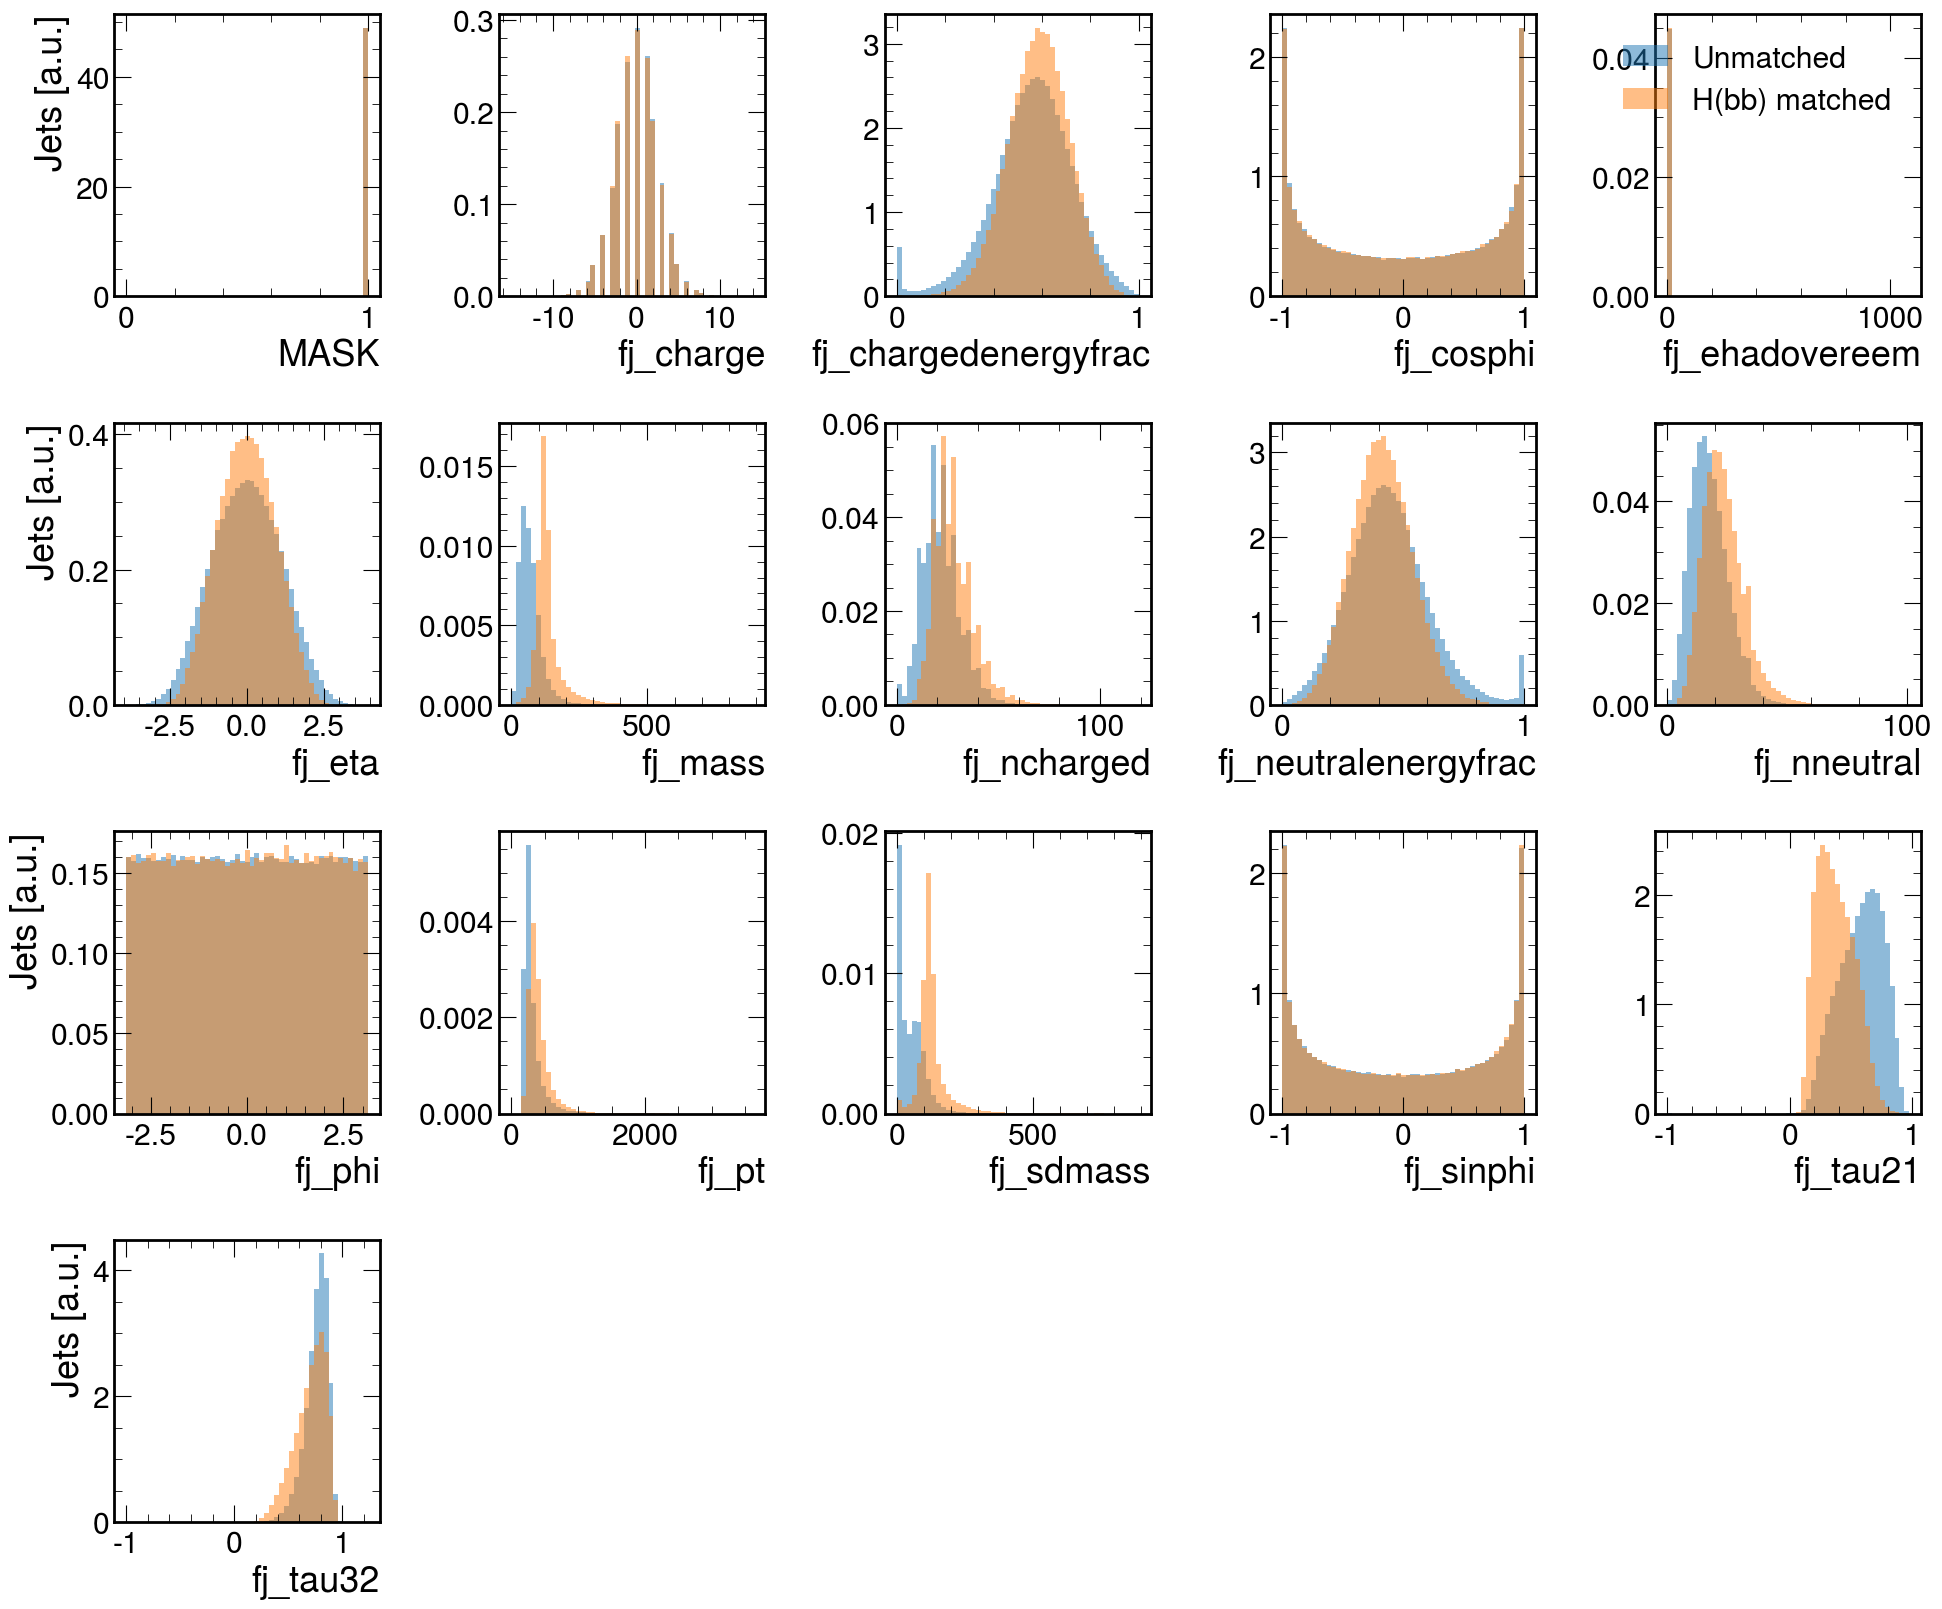

In [286]:
plt.figure(figsize=(20, 20))
for i, key in enumerate(f2["INPUTS"]["BoostedJets"].keys()):
    feature = f2["INPUTS"]["BoostedJets"][key][:].astype(float).flatten()

    xmin = np.min(feature)
    xmax = np.max(feature)
    bins = np.linspace(xmin, xmax, 50)
    plt.subplot(5, 5, i + 1)
    plt.hist(
        feature,
        weights=(1 - mask_signal) * mask_zero,
        bins=bins,
        density=True,
        label="Unmatched",
        histtype="step",
        color="midnightblue",
    )
    plt.hist(
        feature,
        weights=mask_signal * mask_zero,
        bins=bins,
        density=True,
        histtype="step",
        color="firebrick",
        label="H(bb) matched",
    )
    plt.xlabel(key)
    if i == 4:
        plt.legend()
    if i % 5 == 0:
        plt.ylabel("Jets [a.u.]")
plt.tight_layout()
plt.show()

In [258]:
feature_names = [
    "fj_pt",
    "fj_eta",
    # "fj_phi",
    "fj_mass",
    "fj_sdmass",
    # "fj_charge",
    "fj_chargedenergyfrac",
    "fj_ncharged",
    # "fj_neutralenergyfrac",
    "fj_nneutral",
    "fj_tau21",
    "fj_tau32",
]
arrays = []
for key in feature_names:
    feature = f2["INPUTS"]["BoostedJets"][key][:].astype(float).flatten()
    arrays.append(feature[mask_zero.astype(bool)])
data = np.stack(arrays, axis=1)
labels = mask_signal[mask_zero.astype(bool)].astype(bool)
print(data.shape)
print(labels.shape)

(693222, 9)
(693222,)


In [259]:
import xgboost as xgb

# randomly split into training (85%) and validation (15%)

test_size = 0.15
n_samples = data.shape[0]
n_test = int(test_size * n_samples)

np.random.seed(42)
indices = np.random.permutation(n_samples)
data_train = data[indices][n_test:]
data_test = data[indices][:n_test]
labels_train = labels[indices][n_test:]
labels_test = labels[indices][:n_test]

train = xgb.DMatrix(data=data_train, label=labels_train, feature_names=feature_names)
test = xgb.DMatrix(data=data_test, label=labels_test, feature_names=feature_names)
print(f"Number of training samples: {train.num_row()}")
print(f"Number of testing samples: {test.num_row()}")

Number of training samples: 589239
Number of testing samples: 103983


In [272]:
param = {}

param["seed"] = 42  # set seed for reproducibility

# Booster parameters
param["eta"] = 0.1  # learning rate
param["max_depth"] = 5  # maximum depth of a tree
# param["subsample"] = 0.8  # fraction of events to train tree on
# param["colsample_bytree"] = 0.8  # fraction of features to train tree on

# Learning task parameters
param["objective"] = "binary:logistic"  # objective function
param[
    "eval_metric"
] = "error"  # evaluation metric for cross validation, note: last one is used for early stopping
param = list(param.items())

num_trees = 150  # number of trees to make

In [273]:
booster = xgb.train(param, train, num_boost_round=num_trees)

[0]	eval-error:0.12578979256224576


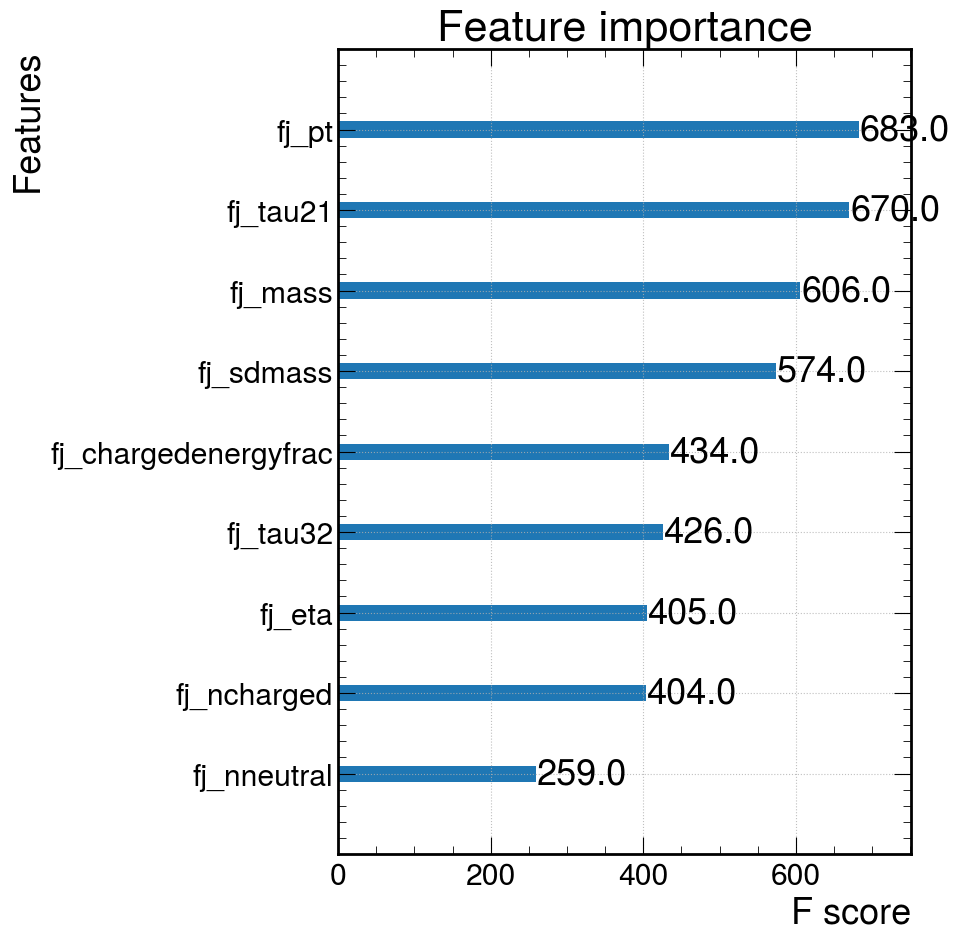

In [289]:
print(booster.eval(test))
predictions_test = booster.predict(test)

xgb.plot_importance(booster)
plt.tight_layout()
plt.show()

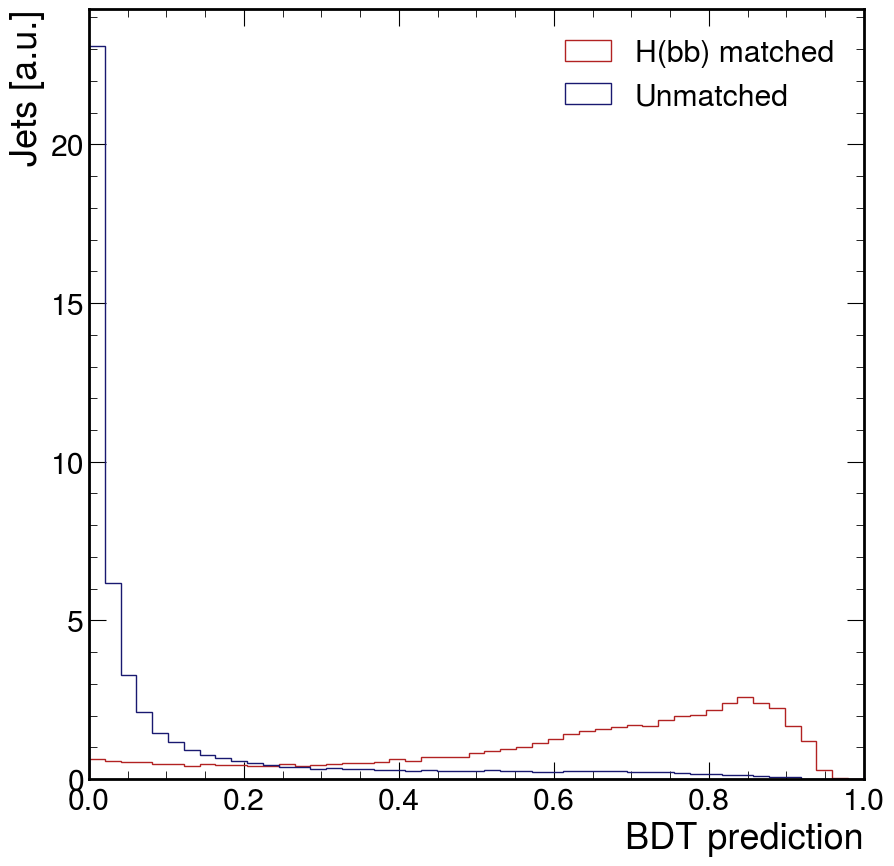

In [290]:
# plot signal and background predictions, separately
plt.figure()
plt.hist(
    predictions_test[labels_test],
    bins=np.linspace(0, 1, 50),
    histtype="step",
    color="firebrick",
    label="H(bb) matched",
    density=True,
)
plt.hist(
    predictions_test[~labels_test],
    bins=np.linspace(0, 1, 50),
    histtype="step",
    color="midnightblue",
    label="Unmatched",
    density=True,
)
# make the plot readable
plt.xlabel("BDT prediction")
plt.ylabel("Jets [a.u.]")
plt.legend(frameon=False)
plt.xlim(0, 1)
plt.show()

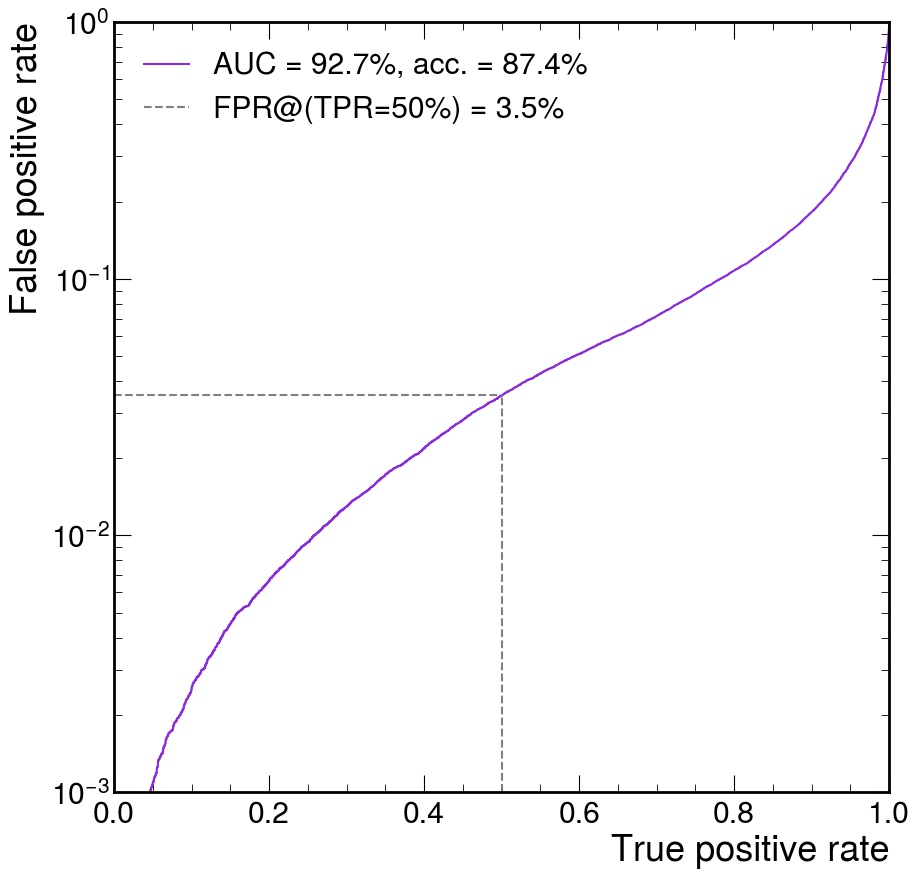

In [291]:
from sklearn.metrics import roc_curve, auc, accuracy_score


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


fpr, tpr, _ = roc_curve(labels_test, predictions_test)
auc_score = auc(fpr, tpr)
acc_score = accuracy_score(labels_test, predictions_test > 0.5)
idx = find_nearest(tpr, 0.5)

# plot TPR vs. FPR (ROC curve)
plt.figure()
plt.plot(
    tpr,
    fpr,
    color="blueviolet",
    label=f"AUC = {auc_score*100:.1f}%, acc. = {acc_score*100:.1f}%",
)
plt.ylabel("False positive rate")
plt.xlabel("True positive rate")
# plot line at TPR =0.5
plt.plot([0.5, 0.5], [0, fpr[idx]], color="gray", linestyle="--")
plt.plot(
    [0, tpr[idx]],
    [fpr[idx], fpr[idx]],
    color="gray",
    linestyle="--",
    label=f"FPR@(TPR=50%) = {fpr[idx]*100:.1f}%",
)
plt.xlim(0, 1)
plt.ylim(1e-3, 1)
plt.semilogy()
plt.legend(frameon=False)
plt.show()